In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS

In [3]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [7]:
baseline_file

'/home/alex/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db'

In [9]:
# Same for rolling cadence
rollDbFile = '/home/alex/rubin_sim_data/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [12]:
# Set range of periods for which we're gonna build the maps
perStep=100
numPoints=500 # This takes a lot of memory, so on 16 GB RAM PC numPoints<150 is recommended
totalObsLength=365*5
#periods=np.round(np.linspace(perStep, numPoints*perStep,numPoints,dtype='float'),3)
periods=np.random.rand(numPoints)*totalObsLength
periods=periods.round(2)
periods.sort()

bundleList=[]
bundleListRoll=[]
ra = [0.]
dec = [-20]


for p in periods:
    metric = KuiperVS(period=p)
    sql = ''
    slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName='KuiperVSTest_'+str(p)))
    bundleListRoll.append(maf.MetricBundle(metric, slicer, sql, runName='RollKuiperVSTest_'+str(p)))

In [13]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['fieldDec', 'fieldRA', 'observationStartMJD', 'rotSkyPos'].
Found 2086980 visits
Running:  ['KuiperVSTest_8_82_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_10_09_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_23_91_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_26_85_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_34_4_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_36_27_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_45_09_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_48_19_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_50_53_KuiperVS_observationStartMJD_USER']
Completed metric genera

Completed metric generation.
Running:  ['KuiperVSTest_315_2_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_315_64_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_315_77_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_315_99_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_321_45_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_323_67_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_330_25_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_339_3_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_347_05_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_348_67_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Run

Completed metric generation.
Running:  ['KuiperVSTest_671_18_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_672_29_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_673_33_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_674_17_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_677_67_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_681_62_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_682_92_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_686_76_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_686_99_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_694_07_KuiperVS_observationStartMJD_USER']
Completed metric generation.
R

Completed metric generation.
Running:  ['KuiperVSTest_925_57_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_934_12_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_938_63_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_942_18_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_943_14_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_945_17_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_949_82_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_950_43_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_953_79_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_955_5_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Ru

Completed metric generation.
Running:  ['KuiperVSTest_1239_42_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1243_52_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1247_78_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1248_49_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1248_64_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1250_51_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1251_03_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1254_77_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1260_35_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1261_2_KuiperVS_observationStartMJD_USER']
Completed metric gene

Completed metric generation.
Running:  ['KuiperVSTest_1523_5_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1527_68_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1552_11_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1554_96_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1565_92_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1568_07_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1571_39_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1572_45_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1573_04_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1573_41_KuiperVS_observationStartMJD_USER']
Completed metric gene

In [14]:
bdRoll = maf.metricBundles.makeBundlesDictFromList(bundleListRoll)
bgRoll = maf.metricBundles.MetricBundleGroup(bdRoll, rollDb, outDir=outDir, resultsDb=resultsDbRoll)
bgRoll.runAll()

Querying database observations with no constraint for columns ['fieldDec', 'fieldRA', 'observationStartMJD', 'rotSkyPos'].
Found 2088105 visits
Running:  ['RollKuiperVSTest_8_82_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_10_09_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_23_91_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_26_85_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_34_4_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_36_27_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_45_09_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_48_19_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_50_53_KuiperVS_observationSta

Completed metric generation.
Running:  ['RollKuiperVSTest_310_3_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_312_94_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_313_91_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_315_2_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_315_64_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_315_77_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_315_99_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_321_45_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_323_67_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_330_25_KuiperVS_observationStartMJD

Completed metric generation.
Running:  ['RollKuiperVSTest_634_92_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_638_49_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_639_32_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_651_12_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_653_28_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_657_47_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_671_18_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_672_29_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_673_33_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_674_17_KuiperVS_observationStartM

Completed metric generation.
Running:  ['RollKuiperVSTest_901_22_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_901_97_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_903_97_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_906_9_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_913_57_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_914_28_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_922_03_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_923_58_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_924_35_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_925_57_KuiperVS_observationStartMJ

Completed metric generation.
Running:  ['RollKuiperVSTest_1198_03_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1204_01_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1212_04_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1217_76_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1224_98_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1228_8_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1229_54_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1231_9_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1235_19_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1235_23_KuiperVS_observati

Completed metric generation.
Running:  ['RollKuiperVSTest_1436_97_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1439_47_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1439_56_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1441_58_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1447_21_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1452_08_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1454_97_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1465_2_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1466_68_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1481_41_KuiperVS_observat

Completed metric generation.
Running:  ['RollKuiperVSTest_1792_32_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1797_69_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1798_73_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1801_15_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1801_95_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1803_85_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1807_08_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1807_13_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1809_03_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_1809_67_KuiperVS_observa

In [15]:
getResultDict=lambda bList:{float(p.runName.split('_')[1]):p.metricValues.data[0] for p in bList}
periods=getResultDict(bundleList)
periodsRoll=getResultDict(bundleListRoll)

Text(0, 0.5, 'Kuiper metric')

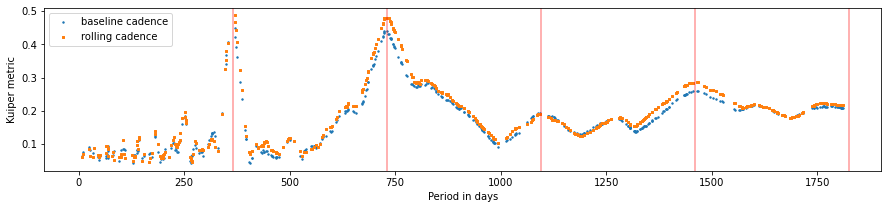

In [40]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods.keys(),periods.values(),s=2,label='baseline cadence')
ax.scatter(periodsRoll.keys(),periodsRoll.values(),marker='s',s=2,label='rolling cadence')
i=0
while i<totalObsLength:
    i+=365
    ax.axvline(i,color='r',alpha=0.4)
ax.legend()
ax.set_xlabel('Period in days')
ax.set_ylabel('Kuiper metric')

In [32]:
df=pd.DataFrame(columns=['periods','kuipMetricBaseline','kuipMetricRolling'],
                   data=zip(periods.keys(),periods.values(),periodsRoll.values()))
df.to_csv('pointKuipValues5years.csv',index=False)

In [17]:
metricPass = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
bundleListPass=[]
bundleListPassRoll=[]

bundleListPass.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPoint'))
bdPass = maf.metricBundles.makeBundlesDictFromList(bundleListPass)
bgPass = maf.metricBundles.MetricBundleGroup(bdPass, conn, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPass.runAll()

bundleListPassRoll.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPointRoll'))
bdPassRoll = maf.metricBundles.makeBundlesDictFromList(bundleListPassRoll)
bgPassRoll = maf.metricBundles.MetricBundleGroup(bdPassRoll, rollDb, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPassRoll.runAll()

Querying database observations with no constraint for columns ['fieldDec', 'fieldRA', 'filter', 'observationStartMJD', 'rotSkyPos', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['PassForAPoint_Pass_filter_observationStartMJD_fiveSigmaDepth_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with no constraint for columns ['fieldDec', 'fieldRA', 'filter', 'observationStartMJD', 'rotSkyPos', 'fiveSigmaDepth'].
Found 2088105 visits
Running:  ['PassForAPointRoll_Pass_filter_observationStartMJD_fiveSigmaDepth_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [18]:
def phasedCadence(period:float,dataSlice,mjdCol:str='observationStartMJD'):
    """
    Returns phase values for the timestamps of observatons
    """
    return (dataSlice[mjdCol]%float(period)/float(period))

In [20]:
import random

/tmp/ipykernel_3811572/3228605529.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


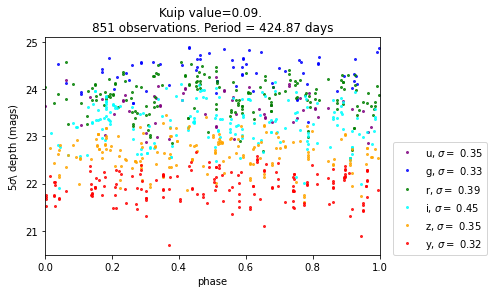

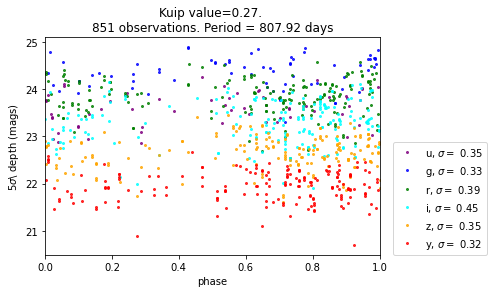

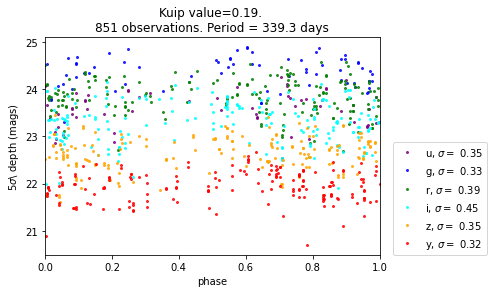

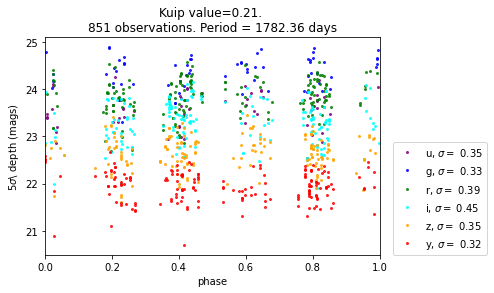

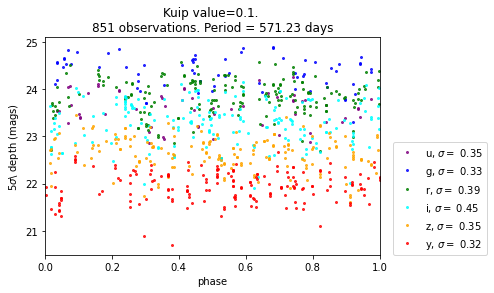

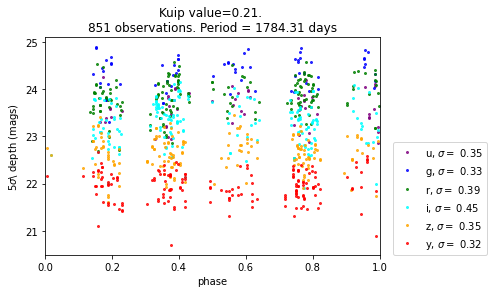

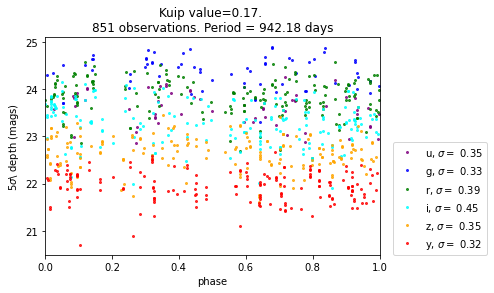

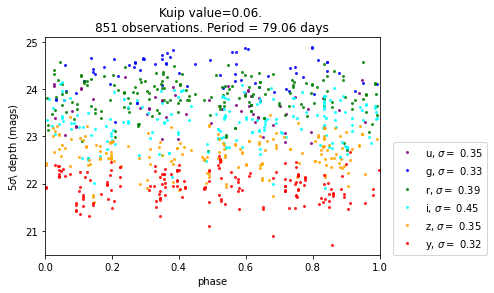

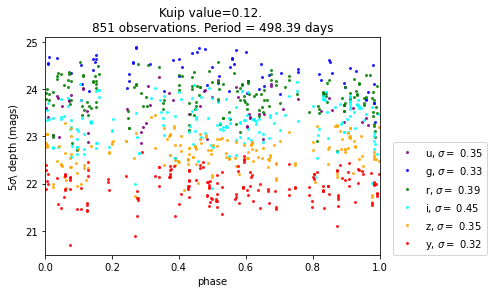

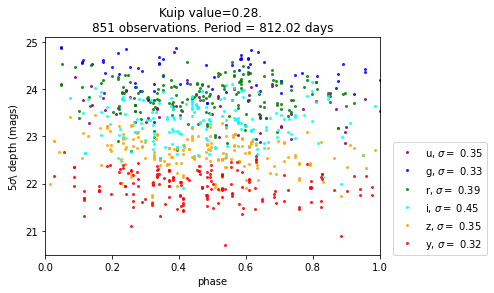

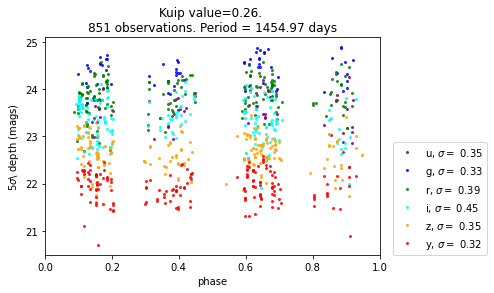

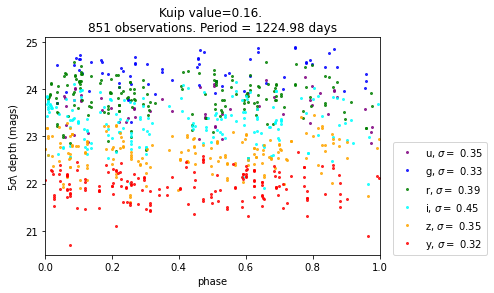

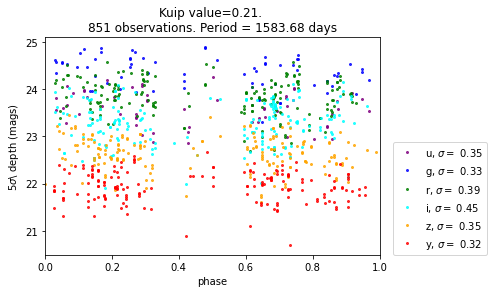

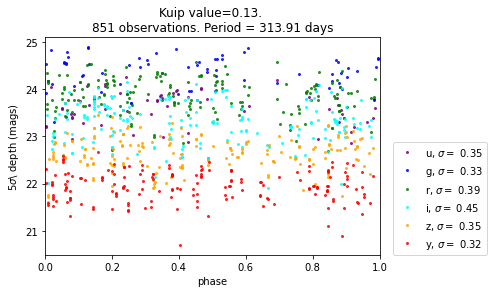

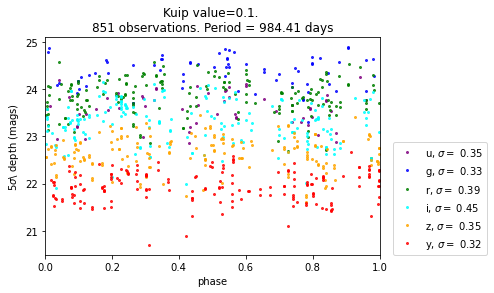

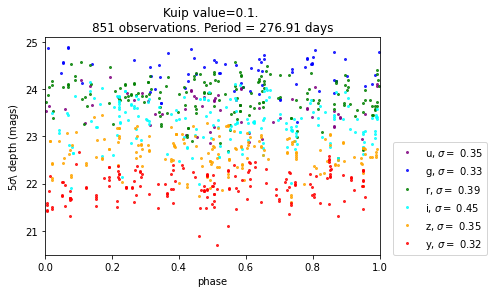

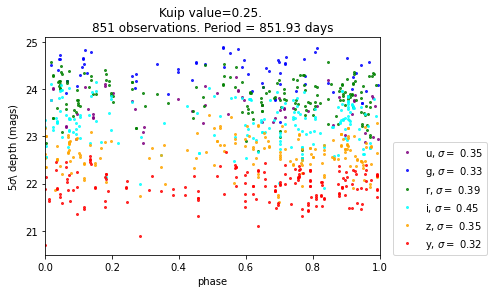

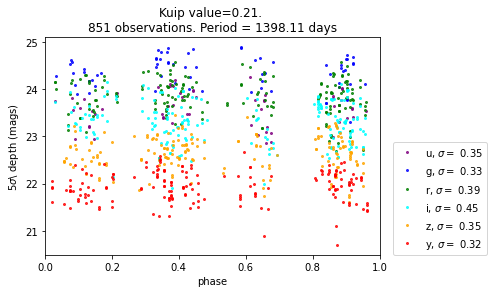

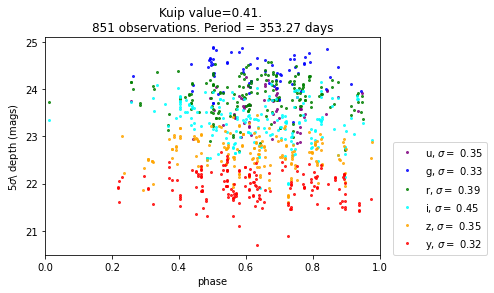

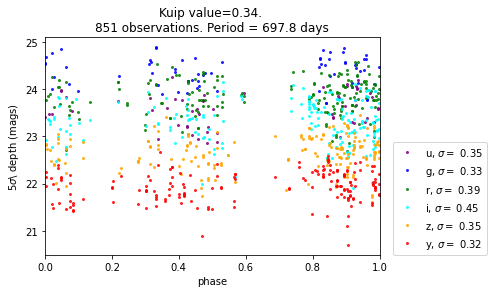

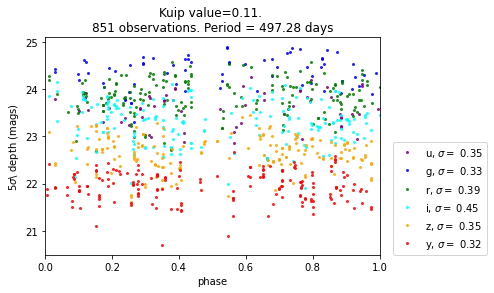

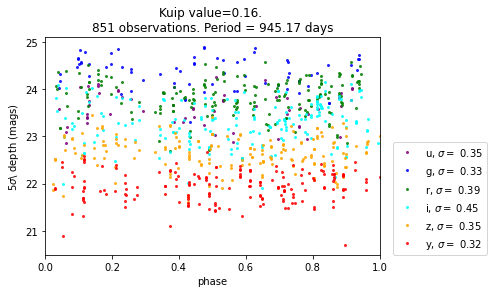

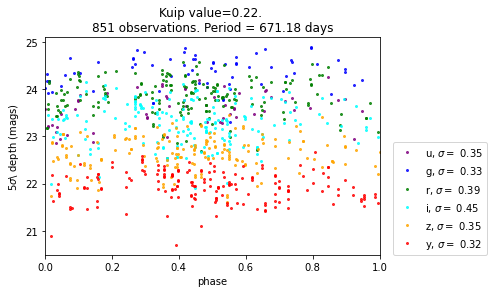

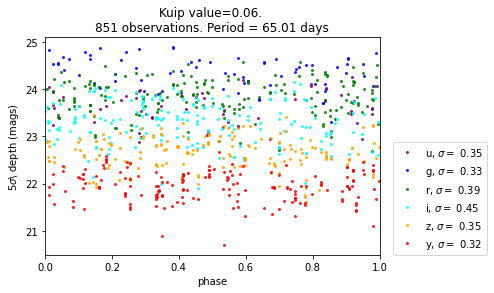

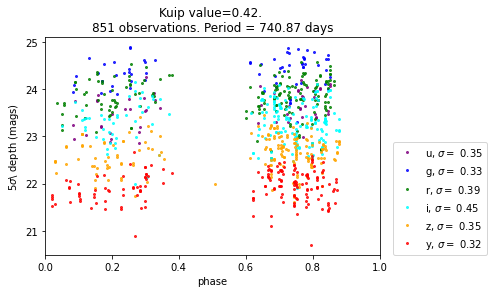

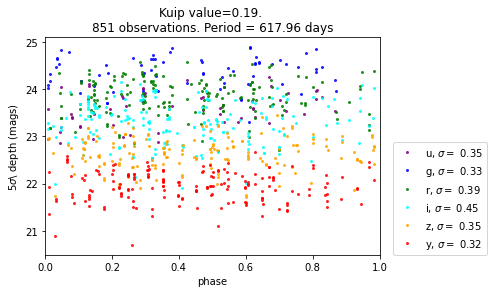

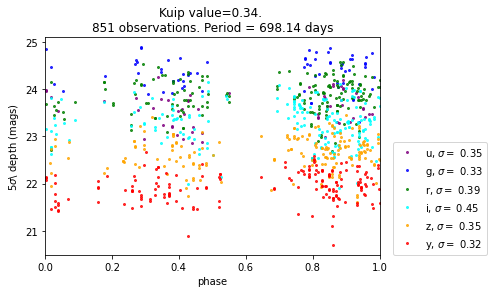

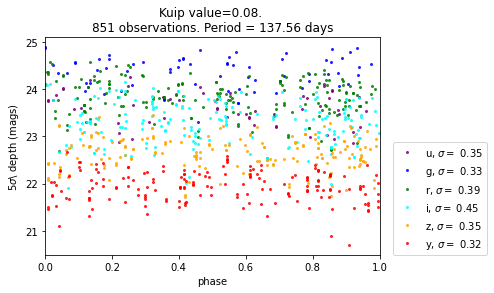

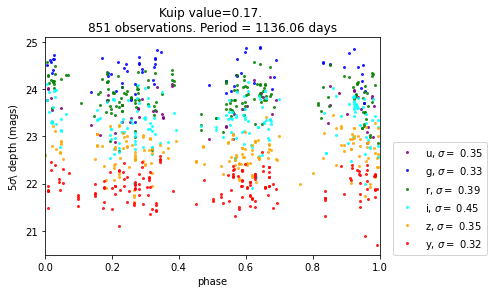

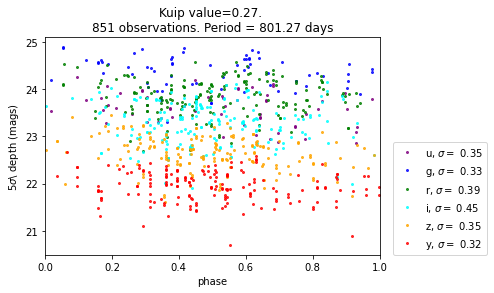

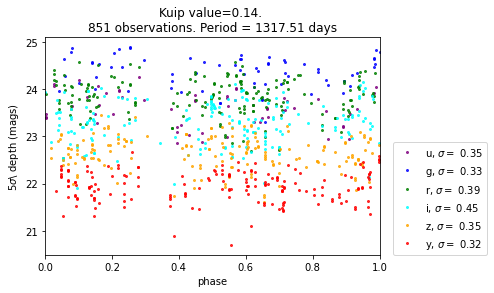

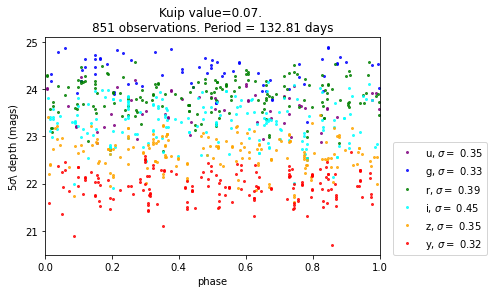

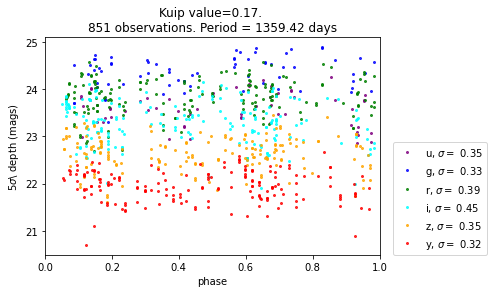

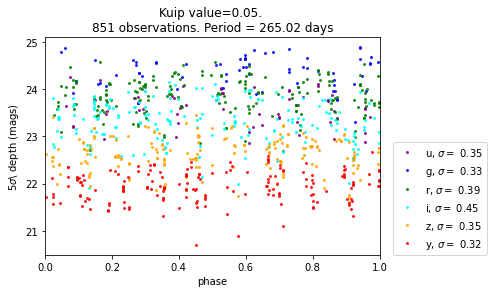

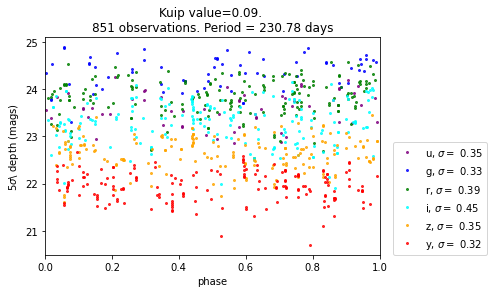

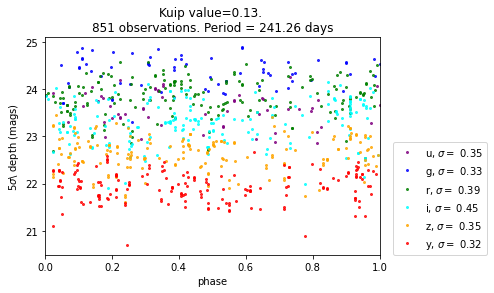

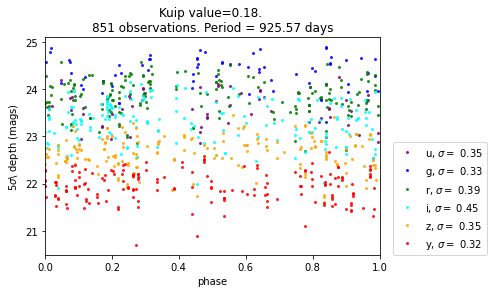

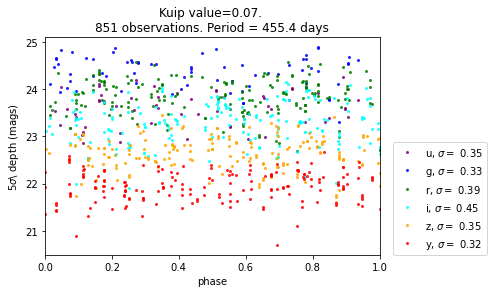

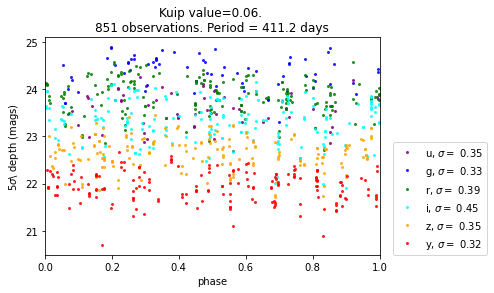

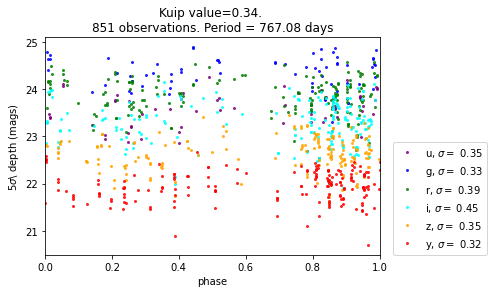

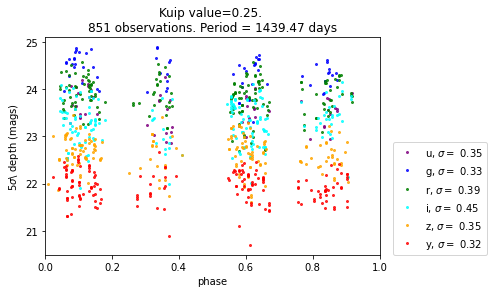

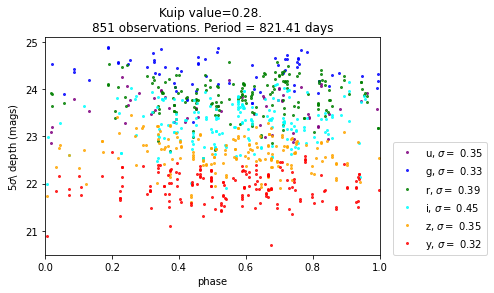

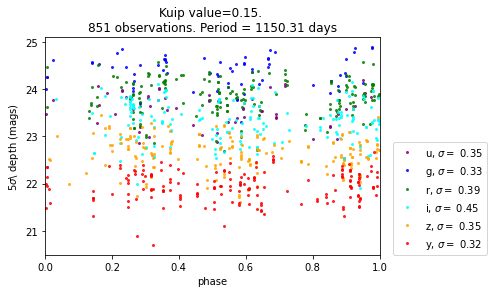

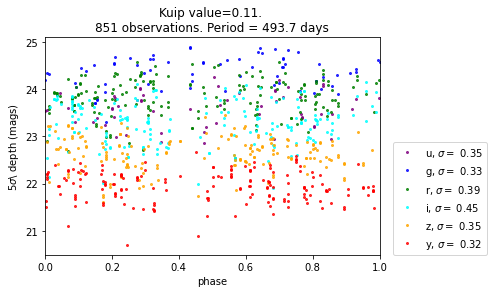

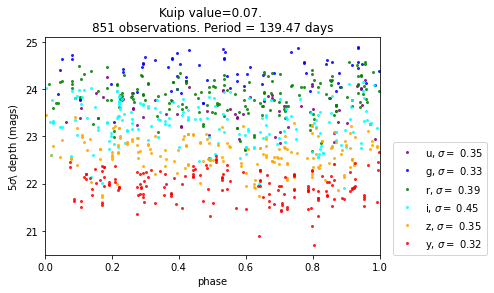

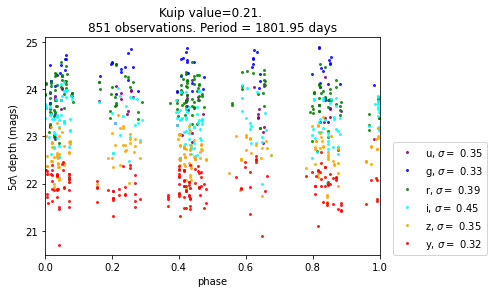

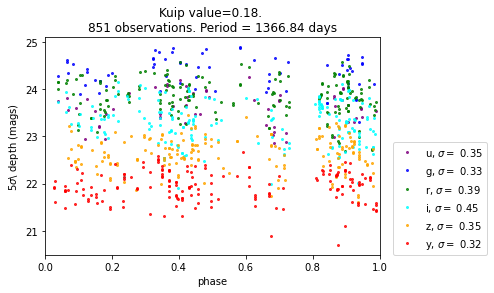

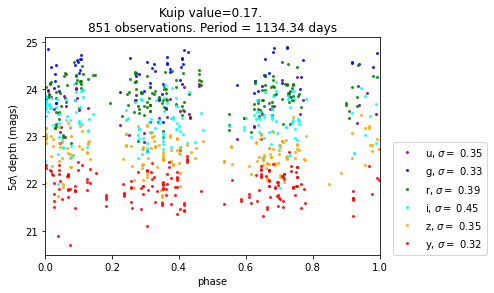

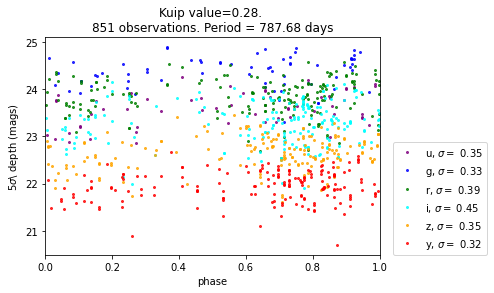

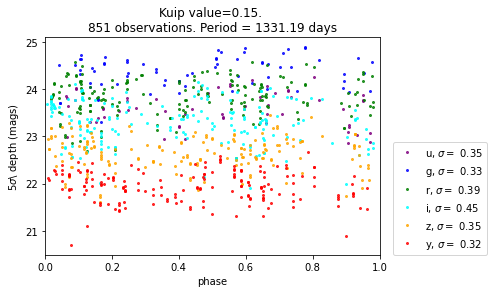

In [25]:
# Plot phased observations 
dataSlice=bundleListPass[0].metricValues.data[~bundleListPass[0].metricValues.mask][0]
new_dt = np.dtype(dataSlice.dtype.descr + [('phasedObs', '<f8')])
dataSlice2 = np.zeros(dataSlice.shape, dtype=new_dt)
for c in dataSlice.dtype.names:
    dataSlice2[c]=dataSlice[c]
    

periodsSample=dict(random.sample(list(periods.items()),50))

for period,kuipVal in periodsSample.items():
    dataSlice2['phasedObs']=phasedCadence(period=period,dataSlice=dataSlice)

    # Let's plot up what the 5-sigma depth looks like
    plt.figure()
    # Give each filter it's own color
    f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}
    for fn in f2c:
        in_filt = np.where(dataSlice2['filter'] == fn)[0]
        plt.plot(dataSlice2['phasedObs'][in_filt],
                 dataSlice2['fiveSigmaDepth'][in_filt], 'o',
                 color=f2c[fn],
                 label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice2['fiveSigmaDepth'][in_filt])),
                 alpha=0.8,
                 markersize=2)
    plt.xlabel('phase')
    plt.ylabel(r'5$\sigma$\ depth (mags)')
    plt.xlim(0,1)
    plt.legend(loc=(1.04,0))
    plt.title('Kuip value='+str(round(kuipVal,2))+'. \n'+
              str(len(dataSlice))+' observations. Period = '+str(period)+' days')